In [1]:
import math
import time
import cv2
from matplotlib import pyplot as plt

In [2]:
from droidlet.lowlevel.hello_robot.hello_robot_mover import HelloRobotMover

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# mover = HelloRobotMover(ip="100.95.90.42")
mover = HelloRobotMover(ip="100.72.46.5")
#mover = HelloRobotMover(ip="192.168.0.216")


In [4]:
from droidlet.dashboard.o3dviz import O3DViz
o3dviz = O3DViz(False)
o3dviz.start()

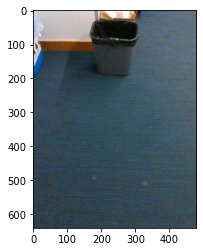

In [5]:
rgb_depth = mover.get_rgb_depth()
img = rgb_depth.rgb
plt.imshow(img)

In [6]:
mover.bot.set_pan(0.0)
time.sleep(2)
mover.bot.set_tilt(- math.radians(90))
time.sleep(2)

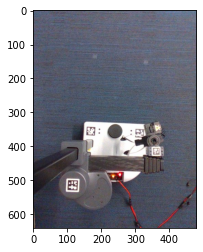

In [7]:
rgb_depth = mover.get_rgb_depth()
img = rgb_depth.rgb
plt.imshow(img)

In [8]:
img.shape

(640, 480, 3)

In [9]:
ARUCO_DICT = {
    # "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
    "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
}


In [10]:
for name, ar in ARUCO_DICT.items():
    arucoDict = cv2.aruco.Dictionary_get(ar)
    arucoParams = cv2.aruco.DetectorParameters_create()
    (corners, ids, rejected) = cv2.aruco.detectMarkers(img, arucoDict, parameters=arucoParams)
    if len(corners) > 0:
        print(name, corners, ids, rejected)

DICT_6X6_1000 (array([[[130., 529.],
        [101., 528.],
        [103., 499.],
        [131., 500.]]], dtype=float32),) [[134]] (array([[[351., 405.],
        [369., 405.],
        [370., 424.],
        [352., 424.]]], dtype=float32), array([[[158., 342.],
        [182., 344.],
        [181., 368.],
        [156., 367.]]], dtype=float32), array([[[ 98., 493.],
        [137., 496.],
        [133., 535.],
        [ 95., 533.]]], dtype=float32))


0.64 0.639 0.643 0.641
[INFO] ArUco marker ID: 134


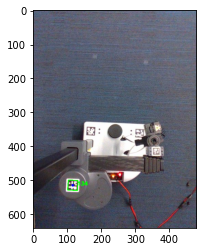

In [11]:
image = img.copy()
depth = rgb_depth.depth
if len(corners) > 0:
    # flatten the ArUco IDs list
    ids = ids.flatten()
    # loop over the detected ArUCo corners
    for (markerCorner, markerID) in zip(corners, ids):
        # extract the marker corners (which are always returned in
        # top-left, top-right, bottom-right, and bottom-left order)
        corners_ = markerCorner.reshape((4, 2))
        (topLeft, topRight, bottomRight, bottomLeft) = corners_
        # convert each of the (x, y)-coordinate pairs to integers
        topRight = (int(topRight[0]), int(topRight[1]))
        bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
        bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
        topLeft = (int(topLeft[0]), int(topLeft[1]))
        # draw the bounding box of the ArUCo detection
        print(depth[topLeft[1], topLeft[0]], depth[topRight[1], topRight[0]],
              depth[bottomLeft[1], bottomLeft[0]], depth[bottomRight[1], bottomRight[0]])
        cv2.line(image, topLeft, topRight, (0, 255, 0), 2)
        cv2.line(image, topRight, bottomRight, (0, 255, 0), 2)
        cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), 2)
        cv2.line(image, bottomLeft, topLeft, (0, 255, 0), 2)
        # compute and draw the center (x, y)-coordinates of the ArUco
        # marker
        cX = int((topLeft[0] + bottomRight[0]) / 2.0)
        cY = int((topLeft[1] + bottomRight[1]) / 2.0)
        cv2.circle(image, (cX, cY), 4, (0, 0, 255), -1)
        # draw the ArUco marker ID on the image
        cv2.putText(image, str(markerID),
            (topLeft[0], topLeft[1] - 15), cv2.FONT_HERSHEY_SIMPLEX,
            0.5, (0, 255, 0), 2)
        print("[INFO] ArUco marker ID: {}".format(markerID))
        # show the output image
        plt.imshow(image)


In [12]:
print(depth.shape)
print(img.shape)

(640, 480)
(640, 480, 3)


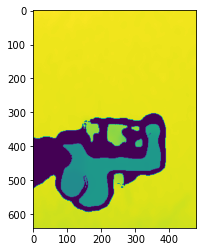

In [13]:
plt.imshow(depth)

In [14]:
pcd = rgb_depth.ptcloud

In [15]:
import open3d as o3d
import numpy as np

In [16]:
pcd.shape

(640, 480, 3)

In [17]:
opcd = o3d.geometry.PointCloud()
opcd.points = o3d.utility.Vector3dVector(pcd.reshape(-1, 3))
opcd.colors = o3d.utility.Vector3dVector(rgb_depth.rgb.reshape(-1, 3))

In [18]:
from droidlet.lowlevel.hello_robot.remote.obstacle_utils import get_ground_plane

In [19]:
ground, rest = get_ground_plane(opcd)

In [20]:
npcd = np.asarray(ground.points)
npcd = np.asarray(ground.points)


In [21]:
npcd.shape

(231914, 3)

In [22]:
z = npcd[:, 2]

In [23]:
print(z.min(), z.max(), np.median(z), z.mean(), z.std())

-0.06127764327377183 0.1017798157613885 0.02435949145258476 0.018839523099827445 0.04321571526724832


[023:750][232456] (stun_port.cc:596): sendto : [0x00000065] Network is unreachable
[031:750][232456] (stun_port.cc:596): sendto : [0x00000065] Network is unreachable
[039:701][232456] (stun_port.cc:96): Binding request timed out from 192.168.0.x:33832 (enp11s0)
[039:701][232456] (stun_port.cc:96): Binding request timed out from 100.127.211.x:36778 (tailscale0)
[039:750][232456] (stun_port.cc:96): Binding request timed out from 100.127.211.x:36778 (tailscale0)
[039:750][232456] (stun_port.cc:96): Binding request timed out from [fd7a:115c:a1e0:x:x:x:x:x]:46178 (tailscale0)


In [26]:
m = np.mean(npcd, axis=0)
X = npcd - m
U, S, V = np.linalg.svd(X, full_matrices=False)
#R = U@(np.diag(S)@V)
normal_vec = V[2,:]
if normal_vec[2]<0:
    normal_vec = -normal_vec
v = o3d.utility.Vector3dVector(np.expand_dims(normal_vec, axis=0))
print(type(ground))
print(type(v))

N = 100
l = 1
point_line = np.zeros((100,3))
for i in range(N):
    point_line[i,:] = l*normal_vec * i/N
point_line_geom = o3d.geometry.PointCloud()
point_line_geom.points = o3d.utility.Vector3dVector(point_line)
#draw(point_line_geom)
from open3d.visualization import draw_geometries
# draw_geometries([ground])
o3dviz.put("ground", ground)
o3dviz.put("vector", point_line_geom)
print(normal_vec)

<class 'open3d.cuda.pybind.geometry.PointCloud'>
<class 'open3d.cuda.pybind.utility.Vector3dVector'>
[-0.10510724 -0.01436194  0.99435718]


In [50]:
arrow = o3d.geometry.TriangleMesh.create_arrow(cylinder_radius=0.05, cone_radius = 0.075,
                                               cylinder_height=0.5, cone_height=0.4, resolution=20)
angle = math.acos(normal_vec[0]) - math.pi/2
arrow = arrow.rotate(arrow.get_rotation_matrix_from_axis_angle([0, -angle , 0]))
print(math.degrees(angle))
o3dviz.put("arrow", arrow)


6.033344982946224
